In [9]:
# Basics
import pandas as pd
import numpy as np
import yfinance as yf
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns

# ML
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# OOP
from pipeline import Pipeline

# Part A - Data Preprocessing

Feature engineering.

**Technical Analysis (TA)** <br>

&#9675; **Moving Average Differential/Spread (`50_20_ma_spread`)**  
  Difference between short-term and long-term moving averages; helps determine directional momentum.  
  If short-term MA > long-term MA = **Bullish** momentum, else **Bearish** momentum.

&#9675; **Exponentially Weighted Volatility (`MSFT_ewm`)**  
  Measures recent volatility with more emphasis on recent returns.  
  Captures regime shifts and fast-changing market risk more responsively than simple rolling volatility.

&#9675; **Log Returns (`*_logreturns`)**  
  Continuous returns used to normalize price changes across assets and maintain time-additivity:
  - `MSFT_logreturns` – Microsoft  
  - `SPY_logreturns` – S&P 500 ETF  
  - `^VIX_logreturns` – Volatility Index  
  - `^TNX_logreturns` – 10-Year Treasury Yield  
  - `XLK_logreturns` – Technology Select Sector ETF

**Supplement Tickers** <br>

&#9675; **SPY** – ETF of the S&P 500; provides overall market direction.  
Features: `SPY_logreturns`, `SPY_volume`

&#9675; **^VIX** – CBOE Volatility Index; reflects implied volatility on SPY options and is often referred to as the "fear gauge".  
Feature: `^VIX_logreturns`

&#9675; **^TNX** – 10-Year Treasury Yield; rising yields signal inflationary pressure and impact equity risk premiums.  
Feature: `^TNX_logreturns`

&#9675; **XLK** – Technology sector ETF; contextualizes sector-specific behavior (especially for MSFT).  
Features: `XLK_logreturns`, `XLK_volume`

&#9675; **MSFT Volume (`MSFT_volume`)** – Total shares traded daily; proxy for liquidity and interest in MSFT.

&#9675; **SPY Volume (`SPY_volume`)** – Market-wide volume benchmark.

&#9675; **Target** – Binary or categorical prediction target (e.g., next-day movement).


In [10]:
pipeline = Pipeline(start='1999-01-01', end='2025-01-03')
df = pipeline.prepare_data

In [11]:
df

,MSFT_logreturns,^TNX_logreturns,SPY_logreturns,XLK_logreturns,MSFT_ewm,VIX,50_20_ma_spread,MSFT_volume,SPY_volume,XLK_volume,Target
Date,,,,,,,,,,,
1999-03-16,0.019034,-0.006454,-0.003817,0.017019,0.007388,25.150000,0.266955,68554000,4547500,758800,0.0
1999-03-17,-0.011526,0.004893,-0.004312,-0.006511,0.005497,25.570000,0.215713,44919600,4524100,425400,1.0
1999-03-18,0.031293,-0.004108,0.015958,0.013841,0.008076,24.129999,0.090487,56231200,3506300,321400,0.0
1999-03-19,-0.007276,0.009172,-0.017144,-0.024349,0.006541,24.320000,-0.028212,91980400,5526700,636500,1.0
1999-03-22,0.009448,0.008896,0.001926,0.000000,0.006832,25.000000,-0.143938,55719200,4603800,773500,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.009330,-0.001741,0.011054,0.010280,0.000338,14.270000,-12.136488,7164500,33160100,2326700,0.0
2024-12-26,-0.002781,-0.002617,0.000067,0.000665,0.000026,14.730000,-12.238154,8194200,41219100,3575400,0.0
2024-12-27,-0.017453,0.008698,-0.010582,-0.013384,-0.001722,15.950000,-12.310184,18117700,64969300,4363200,0.0


In [12]:
split_dict = pipeline.split(df=df, train_proportion=0.90,scale=True)
X_tr_scaled = split_dict['X_tr_scaled']
X_ts_scaled = split_dict['X_ts_scaled']
y_tr = split_dict['y_tr']
y_ts = split_dict['y_ts']

# Part B - EDA + Viz

Viz univariate timeseries.

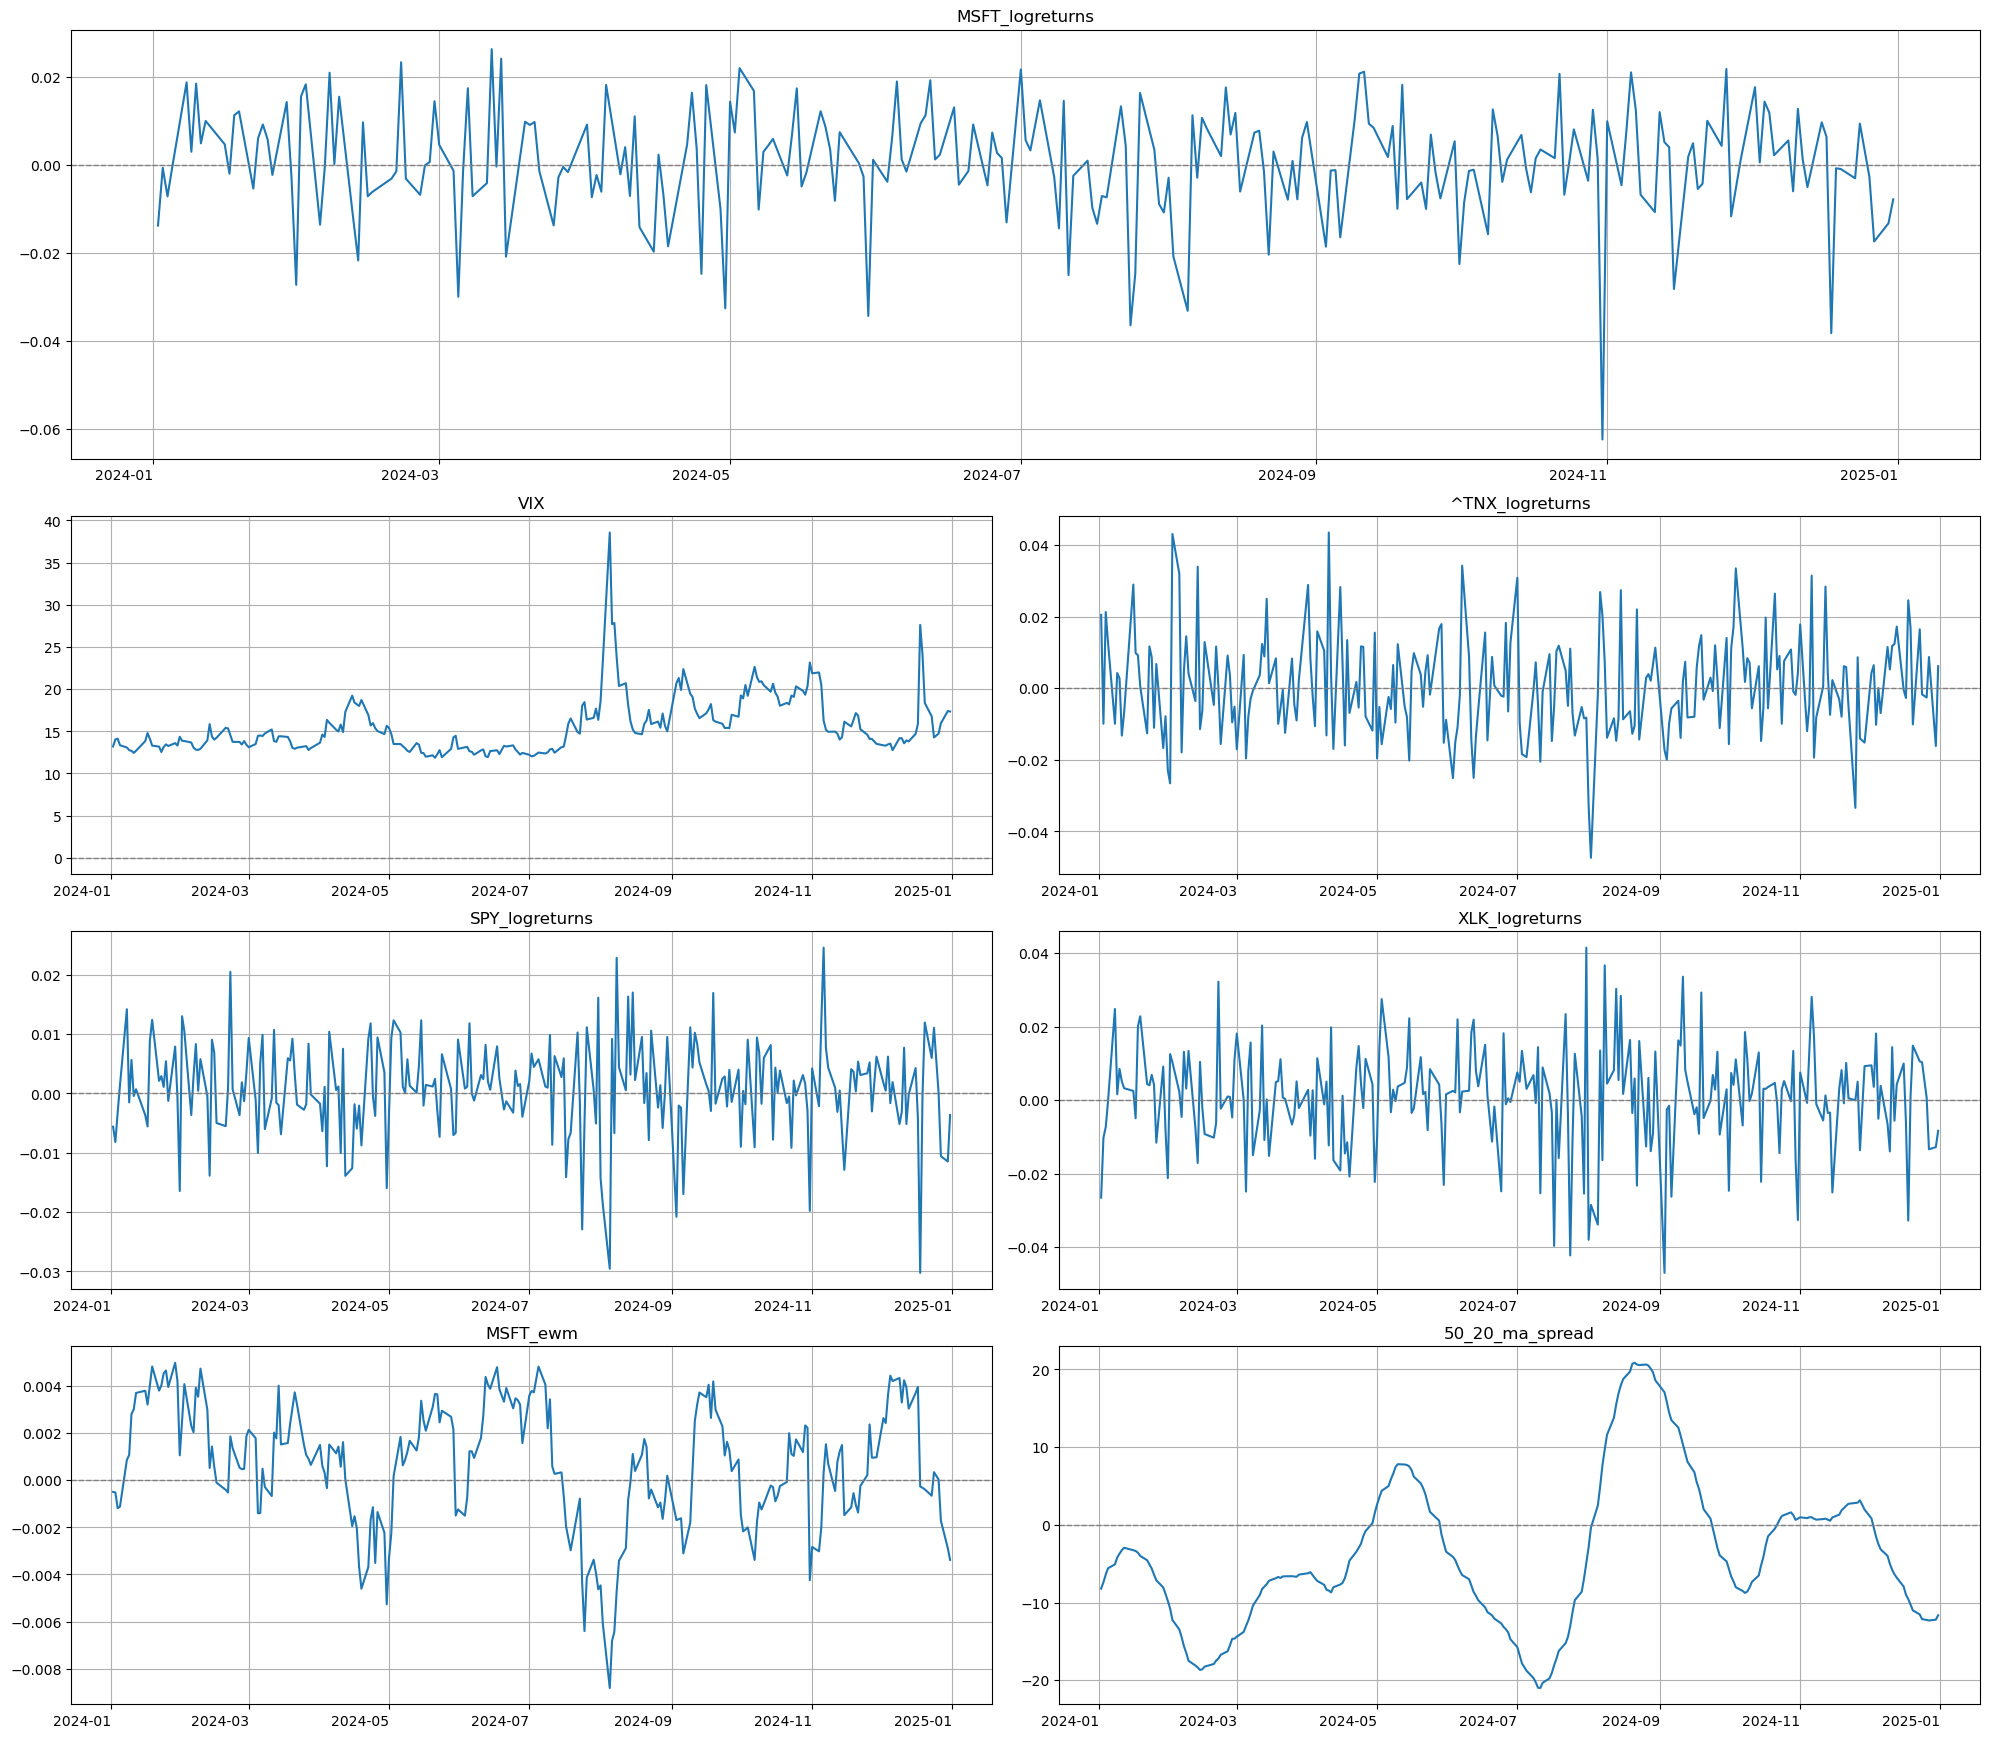

In [15]:
os.makedirs('media', exist_ok = True)
cols_to_plot = ['MSFT_logreturns', 'VIX', '^TNX_logreturns', 
                'SPY_logreturns', 'XLK_logreturns', 'MSFT_ewm', '50_20_ma_spread']

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(4, 2, height_ratios=[1.2, 1, 1, 1])

ax0 = fig.add_subplot(gs[0, :])
df.loc['2024-01-01':, 'MSFT_logreturns'].plot(ax=ax0, title='MSFT_logreturns')
ax0.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax0.grid(True)
ax0.set_xlabel("")
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax0.tick_params(axis='x', labelrotation=0)
other_cols = cols_to_plot[1:]
for i, col in enumerate(other_cols):
    row = (i // 2) + 1
    col_idx = i % 2
    ax = fig.add_subplot(gs[row, col_idx])
    df.loc['2024-01-01':, col].plot(ax=ax, title=col)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax.grid(True)
    ax.set_xlabel("")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.savefig('media/univariate_viz')
plt.show()


...